<a href="https://colab.research.google.com/github/Bohdan-at-Kulinich/Machine-Learning/blob/main/Multiclass_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Single-label multiclass classification

---



In [3]:
# Loadin Reuters dataset: 

from tensorflow.keras.datasets import reuters
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000) 

# restrict the data to the 10,000 most frequently occuring words found in the data 

2121728/2110848 [==============================] - 0s 0us/step


In [5]:
len(train_data) # number of training examples 

8982

In [6]:
len(test_data) # number of test examples 

2246

In [ ]:
# each example is a list of integers:

train_data[10] 

In [ ]:
# decoding newswires back to text: 
word_index = reuters.get_word_index() # dictionary {word : index} 
reverse_word_index = dict( 
    [(value, key) for (key, value) in word_index.items()]) # dictionary {index: word}
decoded_newswire = " ".join(
    [reverse_word_index.get(i-3, "?") for i in train_data[10]]) 

# offset the indices by 3, since 0, 1, 2 are reserved for 'padding', 'start sequence', and 'unknown'. 

In [ ]:
# the labels associated with an example is an integer between 0 and 45: 

train_labels[10]

3

### Preparing the data 

In [7]:
# Encoding the input data: 
# vectorize the data via muli-hot encoding

import numpy as np 

def vectorize_sequence(sequences, dimension=10000):
  results = np.zeros((len(sequences), dimension)) # create an all-zero matrix 
  for i, sequence in enumerate(sequences):
    for j in sequence:
      results[i, j] = 1.  # sets specific indices of results[i] to 1 
  return results 

x_train = vectorize_sequence(train_data)
x_test = vectorize_sequence(test_data) 


In [8]:
# Encoding hte labels: 
# one-hot encoding for categorical data = categorical encoding
# embedding each label as an all-zero vector with 1 in place of the label index

def to_one_hot(labels, dimension=46):
  results = np.zeros((len(labels), dimension))
  for i, label in enumerate(labels):
    results[i, label] = 1. 
  return results 

y_train = to_one_hot(train_labels)
y_test = to_one_hot(test_labels) 

In [9]:
# The built-in way of doing one-hot encoding in Keras:

from tensorflow.keras.utils import to_categorical 
y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels) 

### Model building 

In [10]:
# since the number of output classes is big (46), to prevent the information bottleneck
# which cab be potentially generated if the dimensionality of the Dense layers is too small, 
# we need to increase the number of Dense units to 64

from tensorflow import keras 
from tensorflow.keras import layers 

model = keras.Sequential([
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(46, activation='softmax')
])

# The last Dense layer has the size of 46: for each input sample the network will output a 46-dim vector. 
# Each entry of this vector will encode a different output class. 
# The softmax activation function in the last Dense layer will output a probability distribution over the 46 diff output classes:
# for every input sample, the model produces a 46-dim vector, where the output[i] is the probability that the sample 
# belongs to class i. The 46 scores sum up to 1. 

In [11]:
# The best lost function in this case is categorical_crossentropy, which measures the distance between the prob. distribution output of the model
# and the true distribution of the labels. We attempt to minimize this distance. 

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


### Validation 

In [12]:
# Set apart 1,000 samples in the training data to use as a validation set:

x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = y_train[:1000]
partial_y_train = y_train[1000:]


In [13]:
# Train the model for 20 epochs: 

history = model.fit(partial_x_train, 
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val)) 


Epoch 1/20
16/16 [==============================] - 2s 58ms/step - loss: 2.6273 - accuracy: 0.4733 - val_loss: 1.7675 - val_accuracy: 0.6280
Epoch 2/20
16/16 [==============================] - 1s 46ms/step - loss: 1.4449 - accuracy: 0.7033 - val_loss: 1.3480 - val_accuracy: 0.7160
Epoch 3/20
16/16 [==============================] - 1s 46ms/step - loss: 1.0700 - accuracy: 0.7783 - val_loss: 1.1525 - val_accuracy: 0.7550
Epoch 4/20
16/16 [==============================] - 1s 43ms/step - loss: 0.8415 - accuracy: 0.8212 - val_loss: 1.0490 - val_accuracy: 0.7710
Epoch 5/20
16/16 [==============================] - 1s 43ms/step - loss: 0.6635 - accuracy: 0.8596 - val_loss: 1.0061 - val_accuracy: 0.7750
Epoch 6/20
16/16 [==============================] - 1s 45ms/step - loss: 0.5328 - accuracy: 0.8889 - val_loss: 0.9536 - val_accuracy: 0.7910
Epoch 7/20
16/16 [==============================] - 1s 45ms/step - loss: 0.4262 - accuracy: 0.9095 - val_loss: 0.8920 - val_accuracy: 0.8100
Epoch 8/20
16

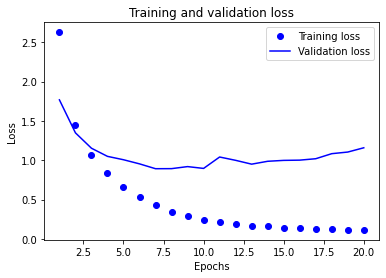

In [17]:
# Plotting the training and validation loss:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, 'b', label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

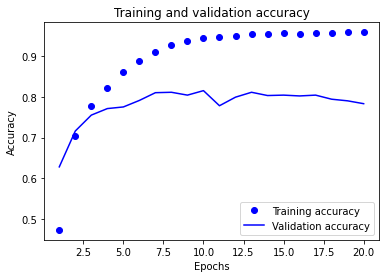

In [18]:
# Plotting the training and validation accuracy:

plt.clf()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [19]:
# The model begins to overfit after 9 epochs. 
# To solve this issue, we retrain the model on the first 9 epochs and then validate it on the test set:

model = keras.Sequential([
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(46, activation='softmax')
])

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train,
          y_train, epochs=9, batch_size=512)

results = model.evaluate(x_test, y_test)

Epoch 1/9
18/18 [==============================] - 2s 42ms/step - loss: 2.6487 - accuracy: 0.5342
Epoch 2/9
18/18 [==============================] - 1s 42ms/step - loss: 1.4042 - accuracy: 0.7102
Epoch 3/9
18/18 [==============================] - 1s 41ms/step - loss: 1.0185 - accuracy: 0.7812
Epoch 4/9
18/18 [==============================] - 1s 42ms/step - loss: 0.7887 - accuracy: 0.8379
Epoch 5/9
18/18 [==============================] - 1s 41ms/step - loss: 0.6219 - accuracy: 0.8692
Epoch 6/9
18/18 [==============================] - 1s 42ms/step - loss: 0.4949 - accuracy: 0.8966
Epoch 7/9
18/18 [==============================] - 1s 41ms/step - loss: 0.3999 - accuracy: 0.9154
Epoch 8/9
18/18 [==============================] - 1s 42ms/step - loss: 0.3245 - accuracy: 0.9302
Epoch 9/9
71/71 [==============================] - 0s 3ms/step - loss: 0.9317 - accuracy: 0.8019


In [20]:
# This approach gives an accuracy of 80%

# The accuracy reaches by a purely random classifier (random baseline): 

import copy
test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
hits_array = np.array(test_labels) == np.array(test_labels_copy)
hits_array.mean() 

# A random classifier would score around 19% accuracy. 

0.18699910952804988

### Generating predictions on new data

In [25]:
predictions = model.predict(x_test) 

# each entry in predictions is a vector of length 46
predictions[0].shape

(46,)

In [26]:
# the coefficients in this vector sum to 1, since they form a probability distribution:

np.sum(predictions[0]) 

1.0

In [28]:
# the largest entry is the predicted class, which has the highest propabability:
np.argmax(predictions[0])

3

In [31]:
# Different way to handle the labels:
# we could cast the labels as an integer tensor:

y_train = np.array(train_labels)
y_test = np.array(test_labels) 

In [ ]:
# To implement this approach, we would need to change the loss function to 
# sparse_categorical_crossentropy

model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']) 